In [1]:
# --- Parámetros (se pueden sobreescribir en CI) ---
RUN_DATE = "2025-09-15"
SEASON   = "2025_26"
MATCHDAY = None
MODEL_VERSION = "xgb-local"

# --- Rutas coherentes local/CI ---
from pathlib import Path
ROOT   = Path.cwd()
DATA   = ROOT / "data"
RAW    = DATA / "01_raw"
PROC   = DATA / "02_processed"
FEAT   = DATA / "03_features"
MODELS = DATA / "04_models"
OUT    = ROOT / "outputs"

for p in [RAW, PROC, FEAT, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

In [2]:
import pandas as pd

def load_raw(name: str):   return pd.read_parquet(RAW / name)
def save_raw(df, name: str):   df.to_parquet(RAW / name, index=False)

def load_proc(name: str):  return pd.read_parquet(PROC / name)
def save_proc(df, name: str):  df.to_parquet(PROC / name, index=False)

def load_feat(name: str):  return pd.read_parquet(FEAT / name)
def save_feat(df, name: str):  df.to_parquet(FEAT / name, index=False)

# **PREPROCESADO**

In [3]:
from google.colab import drive

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eliminación de Variables

Tras la extracción de los datos, llevé a cabo una selección de variables en función del número de valores faltantes que tuviese. Finalmente me quede con todas las variables que no tenian ningún missing (excepto las de xG) ya que eran justo las que necesitaba en un principio.

Después me puse a crear nuevas variables, por lo que se habrán creado nuevos missings que deben ser tratados con cuidado.

Además, este será el preparatorio previo al modelaje. Hay que quedarse con un dataset formado unicamente por números y con las variables justas y necesarias.

In [4]:
IN_PATH = PROC / "df_new_features.parquet"
df = pd.read_parquet(IN_PATH)
df

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,Date,...,home_rivalry_ratio,away_rivalry_ratio,home_prev_big_odds_win_any,away_prev_big_odds_win_any,home_relative_perf_14,away_relative_perf_14,overround,pimp1,pimpx,pimp2
0,7.0,19.0,0.0,17.0,10.0,1.0,1.50,3.75,7.00,2005-08-27,...,0.000000,0.000000,0,0,NaN,NaN,1.076190,0.132743,0.247788,0.619469
1,4.0,19.0,0.0,9.0,2.0,1.0,3.25,3.25,2.00,2005-08-27,...,0.000000,0.000000,0,0,NaN,NaN,1.115385,0.448276,0.275862,0.275862
2,5.0,14.0,0.0,14.0,3.0,3.0,3.25,3.25,2.00,2005-08-27,...,0.000000,0.000000,0,0,NaN,NaN,1.115385,0.448276,0.275862,0.275862
3,4.0,22.0,0.0,9.0,2.0,7.0,4.00,3.40,1.72,2005-08-28,...,0.000000,0.000000,0,0,NaN,NaN,1.125513,0.516560,0.261319,0.222121
4,8.0,25.0,0.0,17.0,6.0,2.0,1.44,4.00,7.50,2005-08-28,...,0.000000,0.000000,0,0,NaN,NaN,1.077778,0.123711,0.231959,0.644330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7646,NaN,NaN,NaN,NaN,NaN,NaN,2.45,3.00,3.20,2025-09-20,...,0.325000,0.325000,0,0,1.219704,1.215500,1.053997,0.296491,0.316257,0.387253
7647,NaN,NaN,NaN,NaN,NaN,NaN,4.10,3.00,2.05,2025-09-21,...,0.222222,0.500000,0,0,1.358116,1.354647,1.065041,0.458015,0.312977,0.229008
7648,NaN,NaN,NaN,NaN,NaN,NaN,3.10,3.30,2.30,2025-09-21,...,0.384615,0.307692,0,0,1.089058,0.833500,1.060394,0.410020,0.285772,0.304208
7649,NaN,NaN,NaN,NaN,NaN,NaN,1.75,3.50,5.00,2025-09-21,...,0.000000,0.000000,0,0,0.491693,0.835017,1.057143,0.189189,0.270270,0.540541


Lo primero es deshacernos de las variables que generan data leakage:

In [5]:
variables_to_drop = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'home_points', 'away_points', 'home_gd', 'away_gd', 'h_xg', 'a_xg']

df = df.drop(columns=variables_to_drop)

# Retraso de las variables de Transfermarkt una temporada

Retraso de las variables de tranfermarkt una temporada:

In [6]:
variables_transfermarkt = [
    'avg_age', 'value_mio', 'value_avg_mio', 'squad_size', 'pct_foreigners'
]

home = df[['Season', 'HomeTeam_norm'] + [f'h_{var}' for var in variables_transfermarkt]].copy()
away = df[['Season', 'AwayTeam_norm'] + [f'a_{var}' for var in variables_transfermarkt]].copy()

home.columns = ['Season', 'Team'] + variables_transfermarkt
away.columns = ['Season', 'Team'] + variables_transfermarkt

team_data = pd.concat([home, away], ignore_index=True).drop_duplicates()

team_data = team_data.sort_values(['Team', 'Season'])

for var in variables_transfermarkt:
    team_data[f'{var}_prev_season'] = team_data.groupby('Team')[var].shift(1)

for var in variables_transfermarkt:
    df = df.merge(
        team_data[['Season', 'Team', f'{var}_prev_season']].rename(columns={
            'Team': 'HomeTeam_norm',
            f'{var}_prev_season': f'h_{var}_prev_season'
        }),
        on=['Season', 'HomeTeam_norm'],
        how='left'
    )

for var in variables_transfermarkt:
    df = df.merge(
        team_data[['Season', 'Team', f'{var}_prev_season']].rename(columns={
            'Team': 'AwayTeam_norm',
            f'{var}_prev_season': f'a_{var}_prev_season'
        }),
        on=['Season', 'AwayTeam_norm'],
        how='left'
    )

In [7]:
variables_transfermarkt = ['avg_age', 'value_mio', 'value_avg_mio', 'squad_size', 'pct_foreigners']

cols_to_drop = [f'h_{var}' for var in variables_transfermarkt] + [f'a_{var}' for var in variables_transfermarkt]

df.drop(columns=cols_to_drop, inplace=True)

In [8]:
df

,B365A,B365D,B365H,Date,FTR,HomeTeam_norm,AwayTeam_norm,h_elo,a_elo,Season,...,h_avg_age_prev_season,h_value_mio_prev_season,h_value_avg_mio_prev_season,h_squad_size_prev_season,h_pct_foreigners_prev_season,a_avg_age_prev_season,a_value_mio_prev_season,a_value_avg_mio_prev_season,a_squad_size_prev_season,a_pct_foreigners_prev_season
0,1.50,3.75,7.00,2005-08-27,D,alaves,barcelona,1644.251709,1892.859375,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.25,3.25,2.00,2005-08-27,H,ath bilbao,sociedad,1741.242554,1716.347778,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.25,3.25,2.00,2005-08-27,H,valencia,betis,1804.846436,1812.068970,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.00,3.40,1.72,2005-08-28,D,ath madrid,zaragoza,1734.815430,1718.908691,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.44,4.00,7.50,2005-08-28,A,cadiz,real madrid,1659.813232,1887.151733,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7646,2.45,3.00,3.20,2025-09-20,None,valencia,ath bilbao,1677.833008,1791.595947,2025,...,26.1,207.7,7.99,26.0,34.62,27.5,365.40,15.23,24.0,8.33
7647,4.10,3.00,2.05,2025-09-21,None,elche,oviedo,1607.261353,1581.857422,2025,...,27.0,67.5,1.69,40.0,42.50,NaN,NaN,NaN,NaN,NaN
7648,3.10,3.30,2.30,2025-09-21,None,vallecano,celta,1666.358765,1671.946899,2025,...,30.1,64.9,2.60,25.0,36.00,26.9,108.50,4.34,25.0,24.00
7649,1.75,3.50,5.00,2025-09-21,None,mallorca,ath madrid,1628.101562,1840.445312,2025,...,28.7,80.4,3.22,25.0,40.00,29.2,508.50,20.34,25.0,68.00


# Valores faltantes

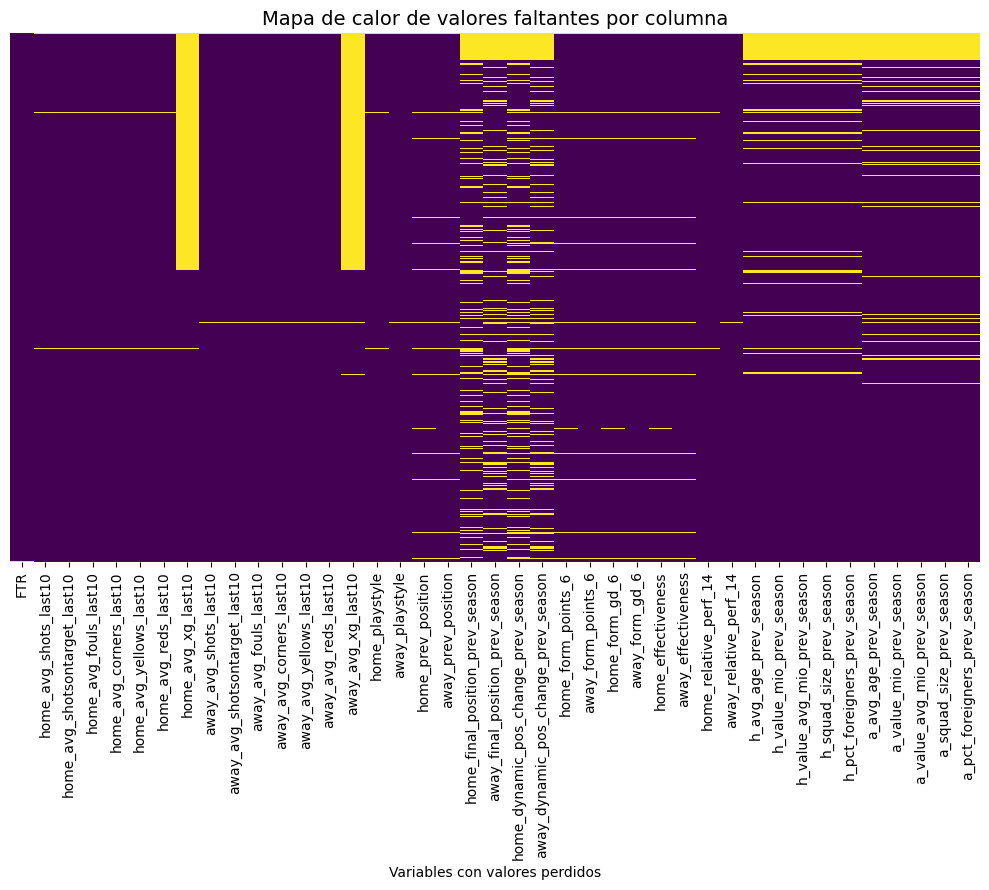

In [9]:
cols_with_missing = df.columns[df.isnull().any()]
df_missing = df[cols_with_missing]

plt.figure(figsize=(10, 9))
sns.heatmap(df_missing.isnull(), cbar=False, cmap="viridis", yticklabels=False)

plt.title("Mapa de calor de valores faltantes por columna", fontsize=14)
plt.xlabel("Variables con valores perdidos")
plt.tight_layout()
plt.show()

Ya que gran parte de las variables presentan la mayor parte de los missing values en la primera temporada de nuestro dataset, la temporada 05/06, procedo a eliminar dicha temporada de mi historial de partidos.

In [10]:
df = df[df['Season'] > 2005].copy()

* **avg_xg_last10**

In [11]:
nas_por_temporada = df.groupby('Season')[['home_avg_xg_last10', 'away_avg_xg_last10']].apply(lambda x: x.isnull().sum())
nas_por_temporada.columns = ['NaNs_home_avg_xg_last10', 'NaNs_away_avg_xg_last10']
nas_por_temporada

,NaNs_home_avg_xg_last10,NaNs_away_avg_xg_last10
Season,,
2006,380,380
2007,380,380
2008,380,380
2009,380,380
2010,380,380
2011,380,380
2012,380,380
2013,380,380
2014,10,10


Solo tengo disponibles estas variables para la mitad de temporadas: 14/15 - 24/25.

Se me ocurren dos soluciones posibles para solucionar el problema:

* Crea una variable indicadora `has_xg_data` (binaria) e imputar los missings a -1 para que el modelo “sepa” que esos -1 no significan realmente que el equipo no jugó mal, sino que el dato no estaba disponible.

* Probar. Hacer un modelo con y otro sin las variables relativas a xg. O incluso hacer un modelo con las temporadas que incluyan las variables de xg.

El resto de valores nulos que hay en las demás temporadas son por equipos recien ascendidos. En ese caso los imputaré a 0.

In [12]:
df['has_xg_data'] = (~df['home_avg_xg_last10'].isna()) & (~df['away_avg_xg_last10'].isna())
df['has_xg_data'] = df['has_xg_data'].astype(int)

cond_early = df['Season'] <= 2013
cond_late = df['Season'] >= 2014

df.loc[cond_early, 'home_avg_xg_last10'] = df.loc[cond_early, 'home_avg_xg_last10'].fillna(-1)
df.loc[cond_early, 'away_avg_xg_last10'] = df.loc[cond_early, 'away_avg_xg_last10'].fillna(-1)

df.loc[cond_late, 'home_avg_xg_last10'] = df.loc[cond_late, 'home_avg_xg_last10'].fillna(0)
df.loc[cond_late, 'away_avg_xg_last10'] = df.loc[cond_late, 'away_avg_xg_last10'].fillna(0)

* **prev_position**

In [13]:
nas_por_temporada = df.groupby('Season')[['home_prev_position', 'away_prev_position']].apply(lambda x: x.isnull().sum())
nas_por_temporada.columns = ['NaNs_home_prev_position', 'NaNs_away_prev_position']
nas_por_temporada

,NaNs_home_prev_position,NaNs_away_prev_position
Season,,
2006,10,10
2007,10,10
2008,10,10
2009,10,10
2010,10,10
2011,10,10
2012,10,10
2013,10,10
2014,10,10


Son NaN en la jornada 1 de cada temporada (porque no hay partidos anteriores).

* Imputar con 0, ya que no indican rendimiento sino ubicación.

In [14]:
df['home_prev_position'] = df['home_prev_position'].fillna(0)
df['away_prev_position'] = df['away_prev_position'].fillna(0)

* **final_position_prev_season** y **dynamic_pos_change_prev_season**

In [15]:
nas_por_temporada = df.groupby('Season')[['home_final_position_prev_season', 'away_final_position_prev_season', 'home_dynamic_pos_change_prev_season', 'away_dynamic_pos_change_prev_season']].apply(lambda x: x.isnull().sum())
nas_por_temporada.columns = ['NaNs_home_final_position_prev_season', 'NaNs_away_final_position_prev_season', 'NaNs_home_dynamic_pos_change_prev_season', 'NaNs_away_dynamic_pos_change_prev_season']
nas_por_temporada

,NaNs_home_final_position_prev_season,NaNs_away_final_position_prev_season,NaNs_home_dynamic_pos_change_prev_season,NaNs_away_dynamic_pos_change_prev_season
Season,,,,
2006,57,57,66,65
2007,57,57,66,65
2008,57,57,65,66
2009,57,57,66,65
2010,57,57,64,67
2011,57,57,66,65
2012,57,57,65,66
2013,57,57,66,65
2014,57,57,66,65


Para las variables `*__final_position_prev_season` tenemos problemas para los equipos recien ascendidos (3 equipos ascendidos x 38 jornadas = 114 partidos sin registro).

Para las `*_dynamic_pos_change_prev_season` además del problema de los equipos recién ascendidos, hace falta una jornada previa para calcularse por eso se suman unos 10 partidos con valores faltantes respecto a las variables anteriores.

Soluciones:

* Imputamos a los recien ascendidos a 20 con un flag

Imputar `final_position_prev_season` como 20 donde falte

In [16]:
df['home_final_position_prev_season'] = df['home_final_position_prev_season'].fillna(20)
df['away_final_position_prev_season'] = df['away_final_position_prev_season'].fillna(20)

Recalcular `dynamic_pos_change_prev_season`:

In [17]:
df['home_dynamic_pos_change_prev_season'] = (
    df['home_prev_position'] - df['home_final_position_prev_season']
)
df['away_dynamic_pos_change_prev_season'] = (
    df['away_prev_position'] - df['away_final_position_prev_season']
)

* **effectiveness**


In [18]:
nas_por_temporada = df.groupby('Season')[['home_effectiveness', 'away_effectiveness']].apply(lambda x: x.isnull().sum())
nas_por_temporada.columns = ['NaNs_home_effectiveness', 'NaNs_away_effectiveness']
nas_por_temporada

,NaNs_home_effectiveness,NaNs_away_effectiveness
Season,,
2006,10,10
2007,10,11
2008,10,10
2009,10,10
2010,11,10
2011,10,10
2012,10,10
2013,10,10
2014,11,10


Los missings en estas variables se deba a que:

* Se calcula como un cociente, y a veces el denominador es cero.

* Se calcula en función de una media acumulada, y en los primeros partidos no hay suficientes datos para computarla.

Lo más facil es imputarlos a 0.

In [19]:
df['home_effectiveness'] = df['home_effectiveness'].fillna(0)
df['away_effectiveness'] = df['away_effectiveness'].fillna(0)

Para el resto de variables con missings values pasa exactamente lo mismo que para esta última, por lo que imputamos los missings restantes a 0.

In [20]:
df = df.fillna(0)

# Pasar todas las variables a numérico

In [21]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Variables categóricas:")
print(categorical_cols.tolist())

Variables categóricas:
['Date', 'FTR', 'HomeTeam_norm', 'AwayTeam_norm', 'home_playstyle', 'away_playstyle', 'home_position_zone', 'away_position_zone']


In [22]:
df['target'] = df['FTR'].map({'A': 0, 'D': 1, 'H': 2})

Las que generan mas dudas sobre su dejarlas o eliminarlas son las de los nombres de los equipos. Si se dejan y hacemos un one hot encoding supondría añadir 80 nuevas variables por lo que resulta muy poco tentador.

In [23]:
position_zone_map = {
    'descenso': 0,
    'mid_table': 1,
    'europa': 2,
    'champions': 3
}

In [24]:
df['home_position_zone'] = df['home_position_zone'].map(position_zone_map)
df['away_position_zone'] = df['away_position_zone'].map(position_zone_map)

In [25]:
df = pd.get_dummies(df, columns=['home_playstyle', 'away_playstyle'], dummy_na=False, drop_first=True)

In [26]:
df = df.drop(columns=['HomeTeam_norm', 'AwayTeam_norm'])

In [27]:
df["FTR"] = df["FTR"].astype(str)

In [28]:
FEAT.mkdir(parents=True, exist_ok=True)

OUT_PATH = FEAT / "df_final.parquet"
df.to_parquet(OUT_PATH, index=False)

print(f"Guardado: {OUT_PATH} · filas={len(df):,} · cols={df.shape[1]}")

Guardado: /content/data/03_features/df_final.parquet · filas=7,271 · cols=72
